<a href="https://colab.research.google.com/github/CaioPadoa/Projetos-DSNP-3.0/blob/main/Churn%20Prediction%20para%20empresas%20de%20telecomunica%C3%A7%C3%B5es%20-%20DSNP%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 3.0**
*by [sigmoidal.ai](https://sigmoidal.ai)*  

---

# Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [1]:
# importar os pacotes necessários
!pip install scikit-plot -q
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.simplefilter("ignore", UserWarning)

# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df_raw = pd.read_csv(DATA_PATH)

# ver as 5 primeiras entradas
df_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
df_raw.shape

(7043, 21)

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Logo de cara, foi possível identificar dois pontos importantes:

* Variável `customerID` não é relevante para a nossa análise
* `TotalCharges` está definida como 'object', e o correto é 'float'. Precisaremos fazer uma correção

In [40]:
df_intermediate = df_raw.copy()

def convert(entrada):
  try:
    return float(entrada)
  except ValueError:
    return np.nan

df_intermediate.drop("customerID", axis = 1, inplace = True)
df_intermediate.TotalCharges = df_intermediate.TotalCharges.apply(convert)

print("Dataset antes da transformação e correção:\n", df_intermediate.isnull().sum().sort_values(ascending = False))

df_intermediate.TotalCharges.fillna(df_intermediate.TotalCharges.median(), inplace = True)
print("\nDataset dedois da transformação e correção:\n",df_intermediate.isnull().sum().sort_values(ascending = False))

Dataset antes da transformação e correção:
 TotalCharges        11
gender               0
SeniorCitizen        0
MonthlyCharges       0
PaymentMethod        0
PaperlessBilling     0
Contract             0
StreamingMovies      0
StreamingTV          0
TechSupport          0
DeviceProtection     0
OnlineBackup         0
OnlineSecurity       0
InternetService      0
MultipleLines        0
PhoneService         0
tenure               0
Dependents           0
Partner              0
Churn                0
dtype: int64

Dataset dedois da transformação e correção:
 gender              0
SeniorCitizen       0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
StreamingTV         0
TechSupport         0
DeviceProtection    0
OnlineBackup        0
OnlineSecurity      0
InternetService     0
MultipleLines       0
PhoneService        0
tenure              0
Dependents          0
Partner             0
Churn              

11 entradas da variável `TotalCharges` foram substituídas pela mediana, já que estavam nulas.

In [5]:
df_intermediate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


Com as mudanças feitas, é hora de analisar os demais ruídos do nosso banco de dados.

Vamos começar analisando a possível existência de outliers nas variáveis quantitativas, através do método do Boxplot

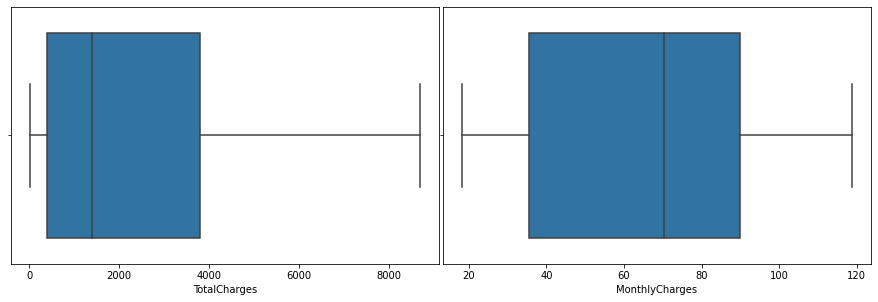

In [6]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

sns.boxplot(df_intermediate.TotalCharges, ax = ax[0])
sns.boxplot(df_intermediate.MonthlyCharges, ax = ax[1])
plt.tight_layout(0);

A visualização do Boxplot demonstra que a base de dados não possui outliers, o que é excelente para a nossa análise.

Agora, vamos conferir a distribuição das variáveis `TotalCharges`e `MonthlyCharges`.

Para isso, utilizaremos o método de Shapiro-Wilk. Para isso, consideraremos um nível de significância de 5%. 

Ou seja, para atestar a normalidade das distribuições, buscamos um p-valor acima de 5%, que aceita a hipótese nula de normalidade.

In [50]:
from scipy import stats
test_shapiro = [df_intermediate.TotalCharges, df_intermediate.MonthlyCharges]

for feature in test_shapiro:
  stats.shapiro(feature)
  if stats.shapiro(feature).pvalue < 0.05:
    print(f"P-valor de {feature.name} =",stats.shapiro(feature).pvalue)
    print("P-valor < 5%, então rejeitamos h0. Portanto, a distribuição de {} não é normal\n".format(feature.name))
  else:
    print(f"P-valor de {feature.name} =",stats.shapiro(feature).pvalue)
    print("P-valor > 5%, então aceitamos h0. Portanto, a distribuição de {} é normal".format(feature))

P-valor de TotalCharges = 0.0
P-valor < 5%, então rejeitamos h0. Portanto, a distribuição de TotalCharges não é normal

P-valor de MonthlyCharges = 0.0
P-valor < 5%, então rejeitamos h0. Portanto, a distribuição de MonthlyCharges não é normal



O teste de Shapiro-Wilk demonstra que as distribuições analisadas não são normais, com um p-valor próximo de 0.

Para concluirmos esse tópico, vamos analisar graficamente as distribuições, comparando-as com uma normal, em questão de Assimetria e Curtose.

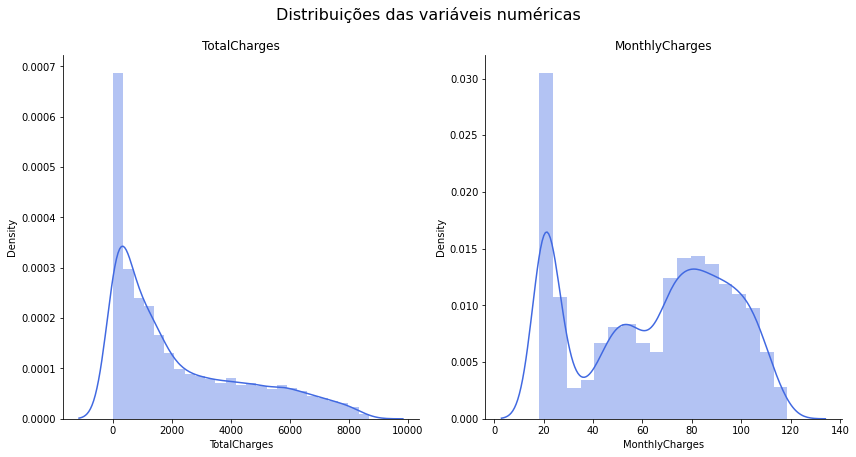

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

sns.distplot(df_intermediate.TotalCharges, norm_hist = True, ax = ax[0], color = "royalblue")
ax[0].set_title("TotalCharges")
ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)

sns.distplot(df_intermediate.MonthlyCharges, norm_hist = True, ax = ax[1], color = "royalblue")
ax[1].set_title("MonthlyCharges")
ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)


plt.suptitle("Distribuições das variáveis numéricas", fontsize = 16, y = 1.05)

plt.tight_layout();

Como é possível observar, nenhuma das variáveis quantitativas possui uma distribuição normal. 


Ambas possuem claros problemas de Assimetria e Curtose.

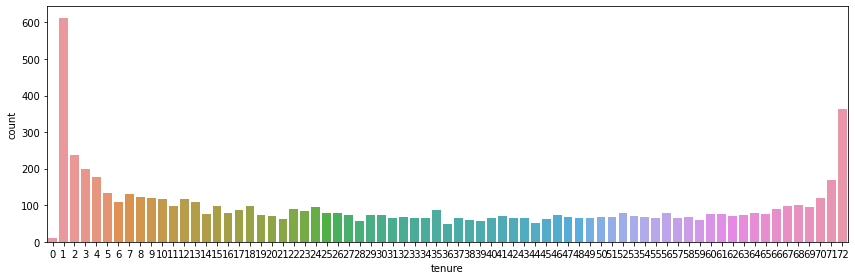

In [9]:
fig, ax = plt.subplots(figsize = (12, 4))
sns.countplot(df_intermediate.tenure)
plt.tight_layout();

A variável `tenure` demonstra, em meses, há quanto tempo os assinantes assinaram o serviço antes de cancelar / estão assinando o serviço.

É possível visualizar que a esmagadora maioria dos clientes se encontra nos primeiros meses de assinatura, entre 1 e 4 meses.

Ademais, pode-se observar outra concentração no outro extremo da variável, com vários clientes assinando o serviço há cerca de 70 meses

In [10]:
df_intermediate.groupby("Churn")["tenure"].mean()

Churn
No     37.569965
Yes    17.979133
Name: tenure, dtype: float64

Os números nos mostram que clientes que assinam o serviço há mais tempo são menos propensos a cancelarem suas assinaturas.

Enquanto a média de `tenure` de clientes que cancelaram a assinatura é de 18 meses, a média para clientes ainda fiéis é de 37.5 meses.

Isso demonstra que, visando a diminuição da taxa de churn, é interessante que a empresa implemente campanhas especiais voltadas para novos assinantes, visando garantir maior permanência na assinatura.

Uma medida possível é a criação de planos mais longos, com vantagens especiais, como bônus, descontos em outras assinaturas (streamings, por exemplo), parcerias, e afins.

In [11]:
df_intermediate.groupby("Churn")["MonthlyCharges"].mean()

Churn
No     61.265124
Yes    74.441332
Name: MonthlyCharges, dtype: float64

In [12]:
df_intermediate.groupby("Churn")["TotalCharges"].mean()

Churn
No     2552.882494
Yes    1531.796094
Name: TotalCharges, dtype: float64

Esses outros dados nos mostram que, apesar de os clientes que não cancelaram suas assinaturas terem pago um valor total maior (pois são clientes há mais tempo), a média de gastos mensal dos clientes que cancelaram seus planos é maior.

Uma recomendação para a empresa é focar nos planos que exigem maior fidelidade do cliente, mas que possuem valores mensais menores nos primeiros meses.

Isso diminuiria a sensação de gasto do consumidor, e aumentaria sua fidelidade para com a empresa, visto que a barreira dos primeiros meses já teria sido quebrada.

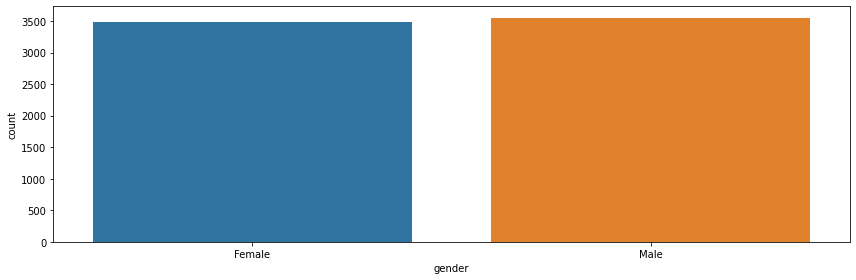

In [13]:
fig, ax = plt.subplots(figsize = (12, 4))
sns.countplot(df_intermediate.gender)
plt.tight_layout();

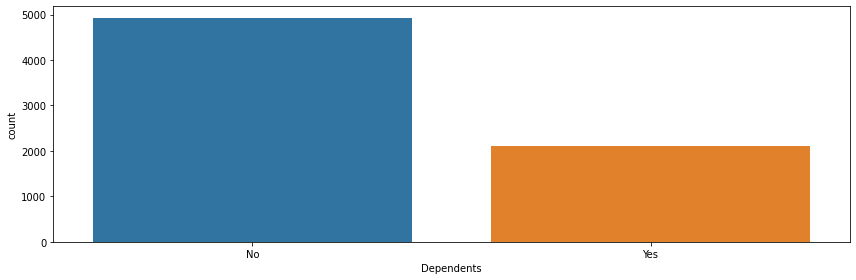

In [14]:
fig, ax = plt.subplots(figsize = (12, 4))
sns.countplot(df_intermediate.Dependents)
plt.tight_layout();

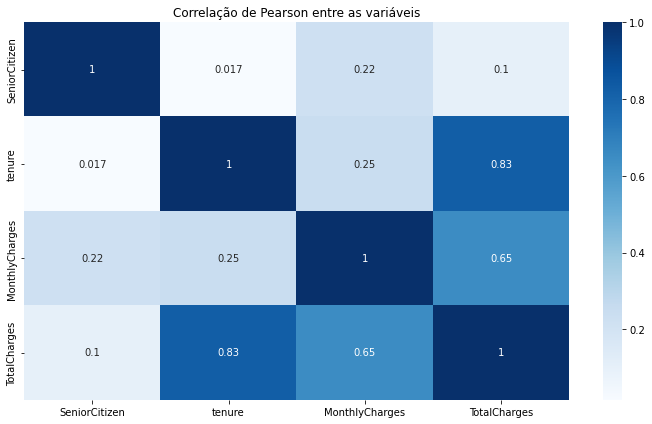

In [15]:
fig, ax = plt.subplots(figsize = (10, 6))

sns.heatmap(df_intermediate.corr(), annot = True, cmap = "Blues")
ax.set_title("Correlação de Pearson entre as variáveis")

plt.tight_layout();

Como esperado, `tenure` tem alta correlação com `TotalCharges`, assim como `MonthlyCharges`

# Preparando os Dados

Com a Análise Exploratória, foi possível pensarmos em alguns insights muito interessantes sobre o negócio e possíveis abordagens sobre o problema da Churn Rate.

Agora, é hora de criarmos um modelo preditivo classificatório, para que possamos prever quando um cliente

Nessa primeira etapa, será feito um split entre dados de treino e de teste.

Logo em seguida, será realizado o pré-processamento dos dados, em que o OneHotEncoder será aplicado para as variáveis categóricas, o LabelEncoder para variáveis binárias e o StandardScaler para variáveis numéricas

In [16]:
df = df_intermediate.copy()

#Train-test split
X = df.drop("Churn", axis = 1)
y = df.Churn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, stratify = y, random_state = 0)

variaveis_binarias = X.nunique()[X.nunique() == 2].keys().tolist()
variaveis_numericas =[col for col in X.select_dtypes(["int", "float"]).columns.tolist() if col not in variaveis_binarias]
variaveis_categoricas = [col for col in X.columns.tolist() if col not in variaveis_numericas + variaveis_binarias]

#Variáveis binárias
le = LabelEncoder()

for i in variaveis_binarias:
  X_train[i] = le.fit_transform(X_train[i])
  X_test[i] = le.transform(X_test[i])

y_train = le.transform(y_train)
y_test = le.transform(y_test)

#Variáveis categóricas
ohe = OneHotEncoder(handle_unknown = "ignore").fit(X_train)
X_train = ohe.transform(X_train)
X_test = ohe.transform(X_test)

#Variáveis numéricas
sc = StandardScaler(with_mean = False).fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

Primeiramente, precisamos descobrir se os dados estão ou não balanceados. Para isso, podemos usar os dados do `df_intermediate`

Distribuição de ocorrências da variável Churn: 
 No     5174
Yes    1869
Name: Churn, dtype: int64


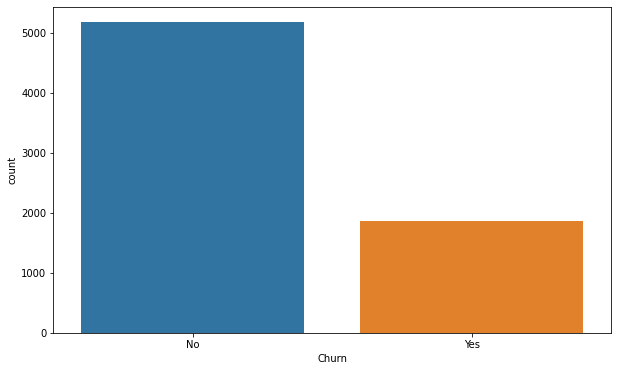

In [31]:
print("Distribuição de ocorrências da variável Churn: \n", df_intermediate.Churn.value_counts())

fig, ax = plt.subplots(figsize = (10, 6))
sns.countplot(df_intermediate.Churn)
plt.show();

Claramente, os dados estão desbalanceados, e isso pode prejudicar gravemente o _recall_ do nosso modelo. 

Para comprovar isso, primeiramente faremos um rápido baseline, com os dados desbalanceados, para mostrar como o modelo seria impreciso.

O modelo escolhido para o baseline será o RandomForestClassifier

In [17]:
#Escolhendo o modelo
rf = RandomForestClassifier()

#Cross-validation com 10 folds
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 0)

scores = cross_val_score(rf, X_train, y_train, scoring = "recall", cv = kfold)
print("Recall: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))

Recall: 0.44 (+/- 0.04)


0.44 é um recall muito baixo, e isso demonstra ainda mais porque o balanceamento do nosso modelo é extremamente necessário.

Utilizaremos o método do RandomUnderSampler para essa função.

In [18]:
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

Com os dados balanceados, iremos testar qual o melhor opção de modelos para a construção do nosso preditor final de Churn Prediction.

In [19]:
#Selecionando opções de modelos
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model = []
recall = []

for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
  model.append(clf.__class__.__name__)
  scores = cross_val_score(clf, X_train_rus, y_train_rus, scoring = "recall", cv = kfold)
  recall.append(scores.mean())

  tests = pd.DataFrame(data=recall, index=model, columns=['Recall'])

tests

,Recall
RandomForestClassifier,0.788209
DecisionTreeClassifier,0.739237
SGDClassifier,0.725526
SVC,0.754592
LogisticRegression,0.770664
XGBClassifier,0.795860
LGBMClassifier,0.765238


O teste nos mostrou que o XGBClassifier foi o modelo com o melhor recall, então ele será escolhido para o tuning de hiperparâmetros, que é a etapa a seguir.

Utilizaremos o RandomizedSearchCV para escolher os melhores hiperparâmetros. Decidi por esse método por conta da otimização da velocidade do modelo, sabendo que o GridSearchCV levaria muito tempo para testar todas as opções.

In [22]:
xgb = XGBClassifier(learning_rate = 0.001)

n_estimators = [int(x) for x in np.linspace(0, 1000, 50)]
max_depth = [int(x) for x in np.linspace(1, 8, 1)]
min_child_weight = [int(x) for x in np.linspace(1, 5, 1)]
gamma = [int(i/10) for i in np.linspace(0, 5)]
learning_rate = np.linspace(start=0.01, stop=1, num=200)

random_grid = {
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "min_child_weight": min_child_weight,
    "gamma": gamma,
    "learning_rate": learning_rate
}

grid_search = RandomizedSearchCV(xgb, random_grid, cv = kfold, scoring = 'recall', verbose = 2, n_jobs = -1, random_state= 0)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print("Melhores parâmetros: ", grid_search.best_params_, "\n",
      "Resultado alcançado: ", grid_result.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Melhores parâmetros:  {'n_estimators': 306, 'min_child_weight': 1, 'max_depth': 1, 'learning_rate': 0.23884422110552767, 'gamma': 0} 
 Resultado alcançado:  0.806570757486788


              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1552
           1       0.50      0.81      0.62       561

    accuracy                           0.74      2113
   macro avg       0.71      0.76      0.71      2113
weighted avg       0.80      0.74      0.75      2113

AUC: 0.7615



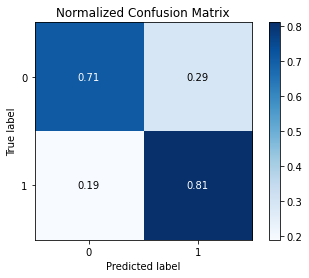

In [26]:
#Modelo final
xgb = XGBClassifier(n_estimators = 306, min_child_weight = 1, max_depth = 1, learning_rate = 0.23884422110552767, gamma = 0)
xgb.fit(X_train_rus, y_train_rus)

#Previsão
y_pred = xgb.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

# Conclusão

Este modelo conseguiu um recall de 81%, o que é excelente para toda e qualquer empresa de Telecomunicações que precise prever sua _churn rate_, visando maximizar seus lucros.

Com a análise exploratória, já foi possível entender a importância da fidelização do cliente nos primeiros meses. Diria que esta deve ser a principal preocupação da companhia, e, nesta etapa, foram feitas algumas sugestões pontuais para que seja possível atingir este objetivo.

Ademais, acredito que o modelo pode ser ainda melhor, com a utilização do GridSearchCV. Isso poderia tornar o tunig de hiperparâmetros ainda mais preciso.